# Convolutional Neural Network (CNN)

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html).


### Import PyTorch

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
from torchvision import datasets
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])
db_train = datasets.CIFAR10(root='./', train=True, transform=transform, download=True)
db_test = datasets.CIFAR10(root='./', train=False, transform=transform, download=True)
def subsample(db, n):
    idx = np.random.permutation(len(db))[:n]
    db.data = db.data[idx]
    db.targets = np.array(db.targets)[idx]
    return db

db_train = subsample(db_train, 5000)
db_test = subsample(db_test, 1000)

img, y = db_train[0]
print(img.shape, img.min(), img.max(), y)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32]) tensor(0.0235) tensor(0.9725) 8


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.
Note that transforms.ToTensor transformed our image 32x32x3 image into a 3x32x32 tensor (the format that Conv2d layers expect). 
However, to display the image, we need to permute its dimensions again.


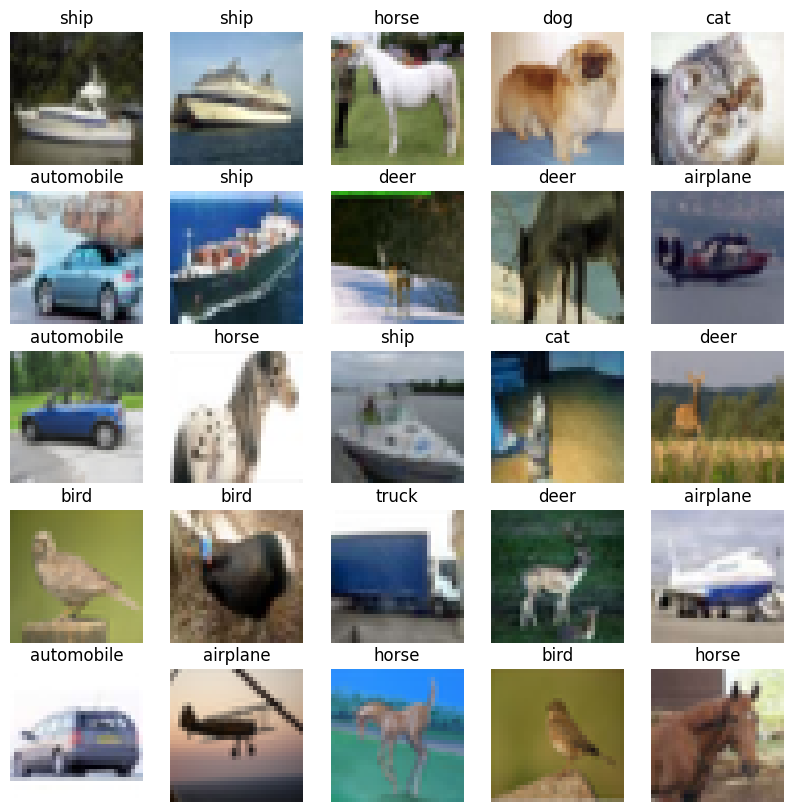

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    img, lbl = db_train[i]
    plt.subplot(5,5,i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[lbl])
    plt.axis(False)
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [MaxPooling2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [7]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(5, 5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(32, 64, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(64, 64, kernel_size=(3, 3)),
    nn.ReLU(),
)
dummy_img = torch.randn(1, 3, 32, 32)
print(model(dummy_img).shape)

torch.Size([1, 64, 12, 12])


The output of every Conv2d and MaxPool2d layer is a 3D tensor of shape (channels, height, width). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2d layer is controlled by the second argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2d layer. By feeding a dummy image, we observe that the model so far will output a (64, 4, 4) tensor.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base of shape (64, 4, 4) into one or more Linear layers to perform classification. Linear layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten the 3D output to 1D, then add one or more Linear layers on top. CIFAR has 10 output classes, so you use a final Linear layer with 10 outputs. Since the convolutional base outputs 64x4x4 tensors, after flattening, we will have 1024 input features to the Linear layer.

In [5]:
model.add_module("flatten", nn.Flatten())
model.add_module("classifier", nn.Linear(1024, 10))

Here's the complete architecture of your model:

In [6]:
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=1024, out_features=10, bias=True)
)


### Compile and train the model

In [7]:
from torch.utils.data import DataLoader
import tqdm

def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, mean=0, std=0.001)

def fit_one_epoch(model, opt, loader):
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        pred = model(images)
        l = loss(pred, labels)
        acc = (pred.argmax(1) == labels).float().mean()
    
        l.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)

@torch.no_grad()
def eval(model, loader):
    accuracies = []
    for images, labels in tqdm.tqdm(loader):
        pred = model(images)
        acc = (pred.argmax(1) == labels).float().mean()
        accuracies.append(acc.detach().item())
    return np.mean(accuracies)


def fit(model, loader_train, loader_test, epochs=50):
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)
    hist_tr_loss, hist_tr_acc, hist_te_acc = [], [], []
    for epoch in range(epochs):
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)
        te_acc = eval(model, loader_test)
        
        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}   Train Acc = {tr_acc:.3f}   Test Acc = {te_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_tr_acc.append(tr_acc)
        hist_te_acc.append(te_acc)
    return hist_tr_loss, hist_tr_acc, hist_te_acc

loader_train = DataLoader(db_train, batch_size=64, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
loss = nn.CrossEntropyLoss()
init_weights(model)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test)

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.88it/s]

Finished epoch 0 of 50: Train Loss = 2.302   Train Acc = 0.104   Test Acc = 0.121



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 53.07it/s]


Finished epoch 1 of 50: Train Loss = 2.205   Train Acc = 0.171   Test Acc = 0.210


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.81it/s]

Finished epoch 2 of 50: Train Loss = 2.064   Train Acc = 0.226   Test Acc = 0.230



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 54.06it/s]

Finished epoch 3 of 50: Train Loss = 1.999   Train Acc = 0.248   Test Acc = 0.265



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.69it/s]

Finished epoch 4 of 50: Train Loss = 1.965   Train Acc = 0.272   Test Acc = 0.262



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.12it/s]

Finished epoch 5 of 50: Train Loss = 1.918   Train Acc = 0.298   Test Acc = 0.319



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 56.42it/s]

Finished epoch 6 of 50: Train Loss = 1.858   Train Acc = 0.328   Test Acc = 0.336



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.58it/s]

Finished epoch 7 of 50: Train Loss = 1.795   Train Acc = 0.349   Test Acc = 0.365



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 50.23it/s]

Finished epoch 8 of 50: Train Loss = 1.766   Train Acc = 0.365   Test Acc = 0.351



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 52.12it/s]

Finished epoch 9 of 50: Train Loss = 1.741   Train Acc = 0.371   Test Acc = 0.344



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.30it/s]

Finished epoch 10 of 50: Train Loss = 1.703   Train Acc = 0.385   Test Acc = 0.371



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 52.88it/s]

Finished epoch 11 of 50: Train Loss = 1.677   Train Acc = 0.390   Test Acc = 0.375



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 54.49it/s]

Finished epoch 12 of 50: Train Loss = 1.650   Train Acc = 0.406   Test Acc = 0.379



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 56.09it/s]

Finished epoch 13 of 50: Train Loss = 1.625   Train Acc = 0.415   Test Acc = 0.387



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 54.31it/s]

Finished epoch 14 of 50: Train Loss = 1.604   Train Acc = 0.421   Test Acc = 0.404



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 54.09it/s]

Finished epoch 15 of 50: Train Loss = 1.571   Train Acc = 0.437   Test Acc = 0.416



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 52.74it/s]

Finished epoch 16 of 50: Train Loss = 1.570   Train Acc = 0.440   Test Acc = 0.400



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.99it/s]

Finished epoch 17 of 50: Train Loss = 1.533   Train Acc = 0.447   Test Acc = 0.427



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.00it/s]

Finished epoch 18 of 50: Train Loss = 1.545   Train Acc = 0.448   Test Acc = 0.425



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.07it/s]

Finished epoch 19 of 50: Train Loss = 1.507   Train Acc = 0.463   Test Acc = 0.434



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 56.50it/s]

Finished epoch 20 of 50: Train Loss = 1.494   Train Acc = 0.463   Test Acc = 0.428



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.60it/s]

Finished epoch 21 of 50: Train Loss = 1.490   Train Acc = 0.461   Test Acc = 0.446



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.27it/s]

Finished epoch 22 of 50: Train Loss = 1.458   Train Acc = 0.472   Test Acc = 0.430



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.44it/s]

Finished epoch 23 of 50: Train Loss = 1.466   Train Acc = 0.478   Test Acc = 0.427



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 53.99it/s]

Finished epoch 24 of 50: Train Loss = 1.436   Train Acc = 0.487   Test Acc = 0.443



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 56.58it/s]

Finished epoch 25 of 50: Train Loss = 1.424   Train Acc = 0.483   Test Acc = 0.450



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.02it/s]

Finished epoch 26 of 50: Train Loss = 1.422   Train Acc = 0.491   Test Acc = 0.440



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 51.24it/s]

Finished epoch 27 of 50: Train Loss = 1.390   Train Acc = 0.502   Test Acc = 0.450



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 53.87it/s]

Finished epoch 28 of 50: Train Loss = 1.384   Train Acc = 0.500   Test Acc = 0.462



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.37it/s]

Finished epoch 29 of 50: Train Loss = 1.365   Train Acc = 0.512   Test Acc = 0.456



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.41it/s]

Finished epoch 30 of 50: Train Loss = 1.348   Train Acc = 0.519   Test Acc = 0.465



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 54.77it/s]

Finished epoch 31 of 50: Train Loss = 1.357   Train Acc = 0.514   Test Acc = 0.441



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 54.14it/s]

Finished epoch 32 of 50: Train Loss = 1.342   Train Acc = 0.520   Test Acc = 0.478



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.86it/s]

Finished epoch 33 of 50: Train Loss = 1.332   Train Acc = 0.521   Test Acc = 0.469



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 54.41it/s]

Finished epoch 34 of 50: Train Loss = 1.308   Train Acc = 0.529   Test Acc = 0.474



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 54.31it/s]

Finished epoch 35 of 50: Train Loss = 1.292   Train Acc = 0.535   Test Acc = 0.466



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.16it/s]

Finished epoch 36 of 50: Train Loss = 1.284   Train Acc = 0.539   Test Acc = 0.486



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 56.00it/s]

Finished epoch 37 of 50: Train Loss = 1.287   Train Acc = 0.545   Test Acc = 0.488



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.44it/s]

Finished epoch 38 of 50: Train Loss = 1.278   Train Acc = 0.550   Test Acc = 0.470



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 48.06it/s]

Finished epoch 39 of 50: Train Loss = 1.254   Train Acc = 0.552   Test Acc = 0.469



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 51.39it/s]

Finished epoch 40 of 50: Train Loss = 1.249   Train Acc = 0.560   Test Acc = 0.481



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 53.54it/s]

Finished epoch 41 of 50: Train Loss = 1.234   Train Acc = 0.556   Test Acc = 0.482



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 51.61it/s]

Finished epoch 42 of 50: Train Loss = 1.229   Train Acc = 0.571   Test Acc = 0.482



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.11it/s]

Finished epoch 43 of 50: Train Loss = 1.222   Train Acc = 0.567   Test Acc = 0.472



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 56.49it/s]

Finished epoch 44 of 50: Train Loss = 1.201   Train Acc = 0.575   Test Acc = 0.466



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 54.97it/s]

Finished epoch 45 of 50: Train Loss = 1.200   Train Acc = 0.573   Test Acc = 0.487



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 56.50it/s]

Finished epoch 46 of 50: Train Loss = 1.193   Train Acc = 0.571   Test Acc = 0.487



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.82it/s]

Finished epoch 47 of 50: Train Loss = 1.165   Train Acc = 0.583   Test Acc = 0.472



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 56.76it/s]

Finished epoch 48 of 50: Train Loss = 1.159   Train Acc = 0.586   Test Acc = 0.477



100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 55.92it/s]

Finished epoch 49 of 50: Train Loss = 1.147   Train Acc = 0.590   Test Acc = 0.466


### Evaluate the model

100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 51.62it/s]


Test accuracy: 0.4658203125


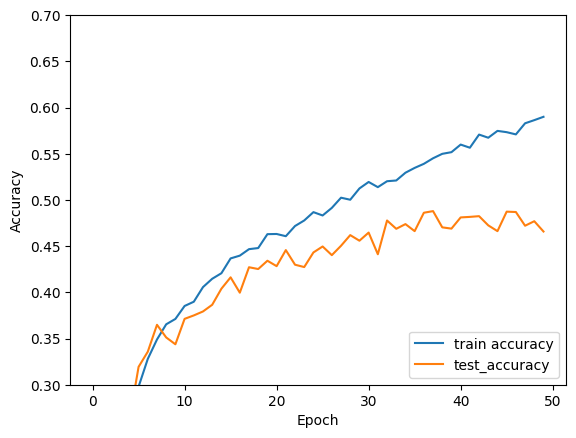

In [8]:
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 0.7])
plt.legend(loc='lower right')

acc = eval(model, loader_test)
print('Test accuracy:', acc)

Now lets display a bunch of predictions of the model

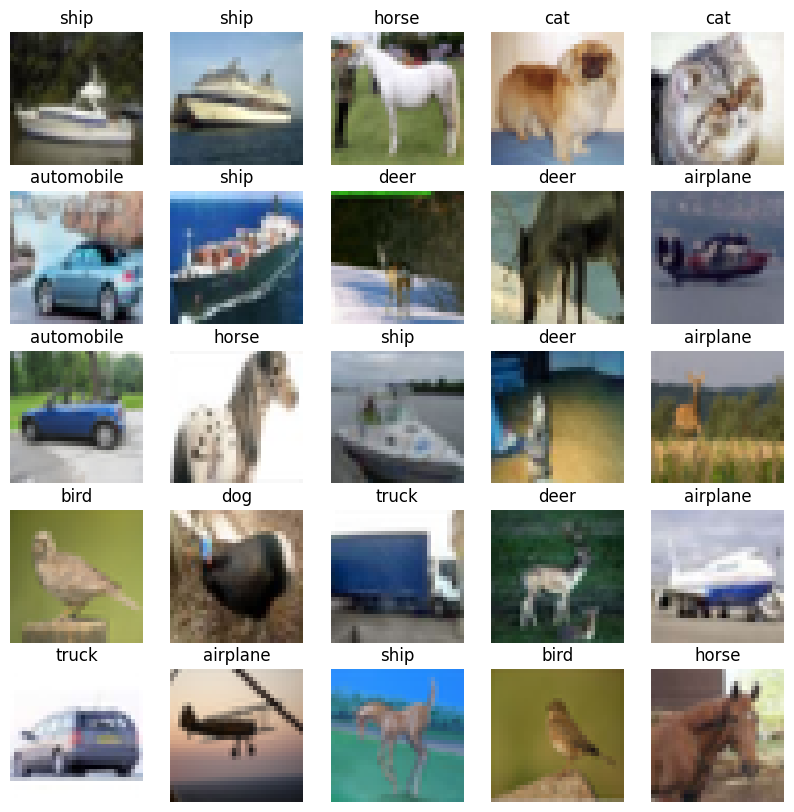

In [9]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    img, lbl = db_train[i]
    with torch.no_grad():
        pred = model(img[None])[0]
        pred = pred.argmax()
    plt.subplot(5,5,i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[pred])
    plt.axis(False)
plt.show()

Now lets see what the model learned at the first layer. Do you recognize any of these filters?

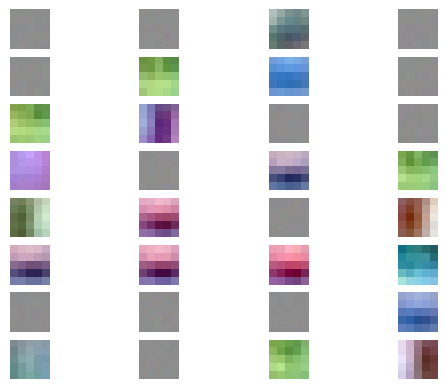

In [10]:
W = (model[0].weight - model[0].weight.min()) / (model[0].weight.max() - model[0].weight.min())
for i in range(32):
    plt.subplot(8, 4, i+1)
    plt.imshow(W[i].permute(1, 2, 0).detach())
    plt.axis(False)